# Generative Adversarial Network

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("brendanartley/cartoon-faces-googles-cartoon-set")

print("Path to dataset files:", path)

100%|██████████| 2.34G/2.34G [00:30<00:00, 81.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/brendanartley/cartoon-faces-googles-cartoon-set/versions/1


In [ ]:
!mv /root/.cache/kagglehub/datasets/brendanartley/cartoon-faces-googles-cartoon-set/versions/1/* /content/files

In [ ]:
!mkdir /content/files/0
!cp -r /kaggle/input/cartoon-faces-googles-cartoon-set/cartoonset100k_jpg/0/* /content/files/0

mkdir: cannot create directory ‘/content/files/0’: File exists
cp: cannot stat '/kaggle/input/cartoon-faces-googles-cartoon-set/cartoonset100k_jpg/0/*': No such file or directory


In [ ]:
import os

DATA_DIR = './files'
print(os.listdir(DATA_DIR))

['0', '9', '6', '2', '7', '5', '1', '3', '8', '4']


In [ ]:
print(os.listdir(DATA_DIR+'/0')[:5])

['cs11684425351607321221.jpg', 'cs11800325467267052367.jpg', 'cs12093131052040443094.jpg', 'cs11555914327205483861.jpg', 'cs12007822214048452358.jpg']


# Dataset Loading & Preprocessing

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

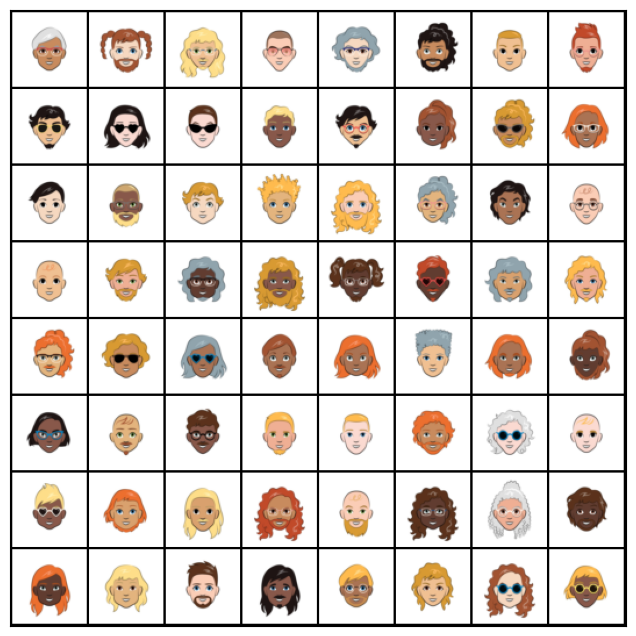

In [ ]:
show_batch(train_dl)

# GPU setup

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

# Discriminator Network

We'll use a convolutional neural networks (CNN) which outputs a single number output for every image.

In [ ]:
import torch.nn as nn

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

# Generator Network

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 128, 1, 1])
torch.Size([128, 3, 64, 64])


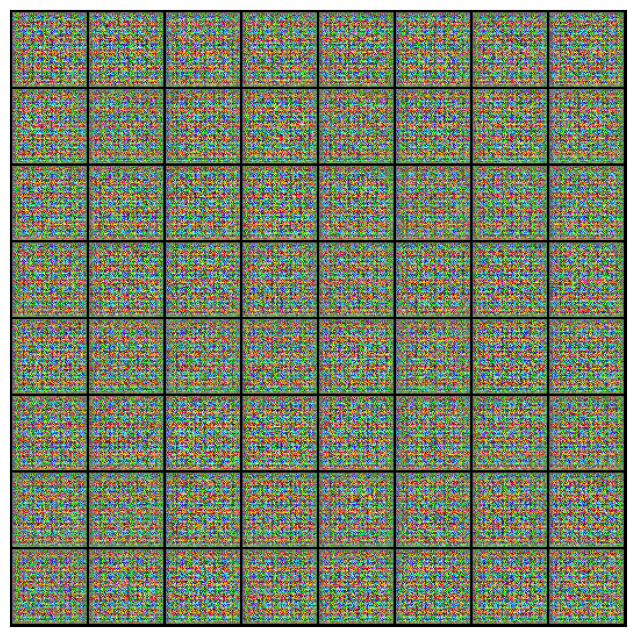

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(xb.shape)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

# Discriminator Training

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

# Generator Training

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


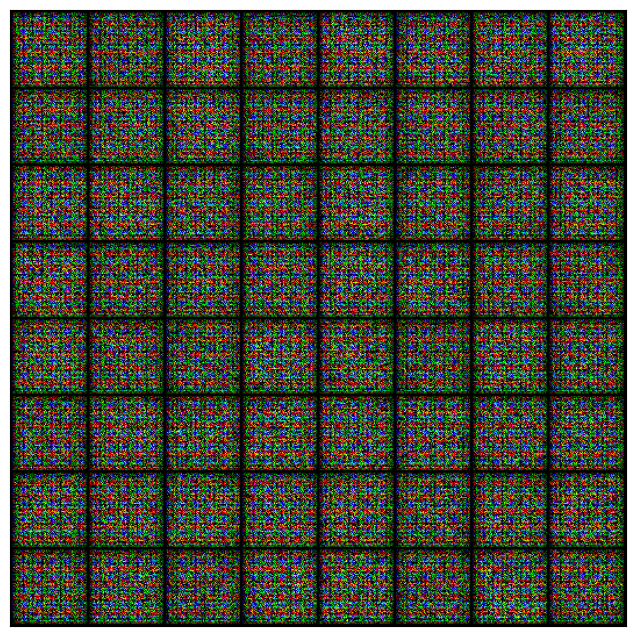

In [ ]:
save_samples(0, fixed_latent)

# Full Training Loop

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 10

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 3.4305, loss_d: 0.1646, real_score: 0.9430, fake_score: 0.0908
Saving generated-images-0001.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 0.8434, loss_d: 0.2371, real_score: 0.8194, fake_score: 0.0219
Saving generated-images-0002.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 4.2794, loss_d: 0.0491, real_score: 0.9686, fake_score: 0.0155
Saving generated-images-0003.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 6.0790, loss_d: 0.0609, real_score: 0.9768, fake_score: 0.0313
Saving generated-images-0004.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 5.6990, loss_d: 0.1152, real_score: 0.9731, fake_score: 0.0823
Saving generated-images-0005.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 6.6128, loss_d: 0.0706, real_score: 0.9984, fake_score: 0.0626
Saving generated-images-0006.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 5.8041, loss_d: 0.0434, real_score: 0.9873, fake_score: 0.0289
Saving generated-images-0007.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 3.9940, loss_d: 0.1704, real_score: 0.9113, fake_score: 0.0482
Saving generated-images-0008.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 4.9834, loss_d: 0.0681, real_score: 0.9615, fake_score: 0.0270
Saving generated-images-0009.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 0.5711, loss_d: 0.1851, real_score: 0.8601, fake_score: 0.0033
Saving generated-images-0010.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 9.8282, loss_d: 0.0608, real_score: 0.9550, fake_score: 0.0039
Saving generated-images-0011.png


  0%|          | 0/782 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')

In [ ]:
import cv2
import os

vid_frame = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_frame, cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()